In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [16]:
def get_linear_likes(user_likes, user_views, ctr_control):
    linear_likes = user_likes - ctr_control*user_views
    return linear_likes

In [31]:
control_group = 0
test_group = 3

In [32]:
def get_datafrom_db( group1_str, group2_str):
    connection = {
        'host': 'https://clickhouse.lab.karpov.courses',
        'password': 'dpo_python_2020',
        'user': 'student',
        'database': 'simulator_20230120'
    }

    q = """
    SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr

    FROM simulator_20230120.feed_actions
    WHERE toDate(time) between '2023-01-01' and '2023-01-07'
        and exp_group in ({group1},{group2})
    GROUP BY exp_group, user_id""".format(group1 = group1_str, group2 = group2_str)

    # Вытащили пользователей
    return ph.read_clickhouse(q, connection=connection)

In [71]:

df_l.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


In [103]:
control_group = 1
test_group = 2

df_l = get_datafrom_db(control_group,test_group)
stats.ttest_ind(df_l[df_l.exp_group == control_group].ctr,
                    df_l[df_l.exp_group == test_group].ctr,
                    alternative='two-sided',
                    equal_var=False)


Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

In [98]:
def ctr_plot(user_param):
    # Сделаем графики в seaborn покрупнее
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    groups = sns.histplot(data = user_param, 
                  x='ctr', 
                  hue='exp_group', 
                  palette = ['r', 'b'],
                  alpha=0.5,
                  kde=False)
#ctr_plot(user_df)

In [107]:
def linearized_likes_runnig(control_group, test_group):
    print("тест групп",control_group, test_group)
    user_df_tmp = get_datafrom_db( control_group, test_group)
    ctr_plot(user_df_tmp)
    
    stat, pvalue = stats.ttest_ind(user_df_tmp[user_df_tmp.exp_group == control_group].ctr,
                                   user_df_tmp[user_df_tmp.exp_group == test_group].ctr,
                                   alternative='two-sided',
                                   equal_var=False)
    print("t-тест между группами {} и {} по ctr".format(control_group, test_group), stat, pvalue)
    
    
    # Считаем общий CTR в контрольной группе
    ctr_control = user_df_tmp[user_df_tmp.exp_group == control_group].likes.sum()/user_df_tmp[user_df_tmp.exp_group == control_group].views.sum()
    
    #Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
    group_control = user_df_tmp[user_df_tmp.exp_group == control_group].copy()
    group_control['linear_likes'] = user_df_tmp.apply(lambda x: get_linear_likes(x['likes'], x['views'], ctr_control), axis=1)

    group_test = user_df_tmp[user_df_tmp.exp_group == test_group].copy()
    group_test['linear_likes'] = user_df_tmp.apply(lambda x: get_linear_likes(x['likes'], x['views'], ctr_control), axis=1)
    
    stat, pvalue = stats.ttest_ind(group_control.linear_likes,
                                   group_test.linear_likes,
                                   alternative='two-sided',
                                   equal_var=False)
    print("анализ тестa между группами {} и {} по метрике линеаризованных лайков".format(control_group, test_group) ,stat, pvalue)

тест групп 0 3
t-тест между группами 0 и 3 по ctr -13.896870721904069 1.055849414662529e-43
анализ тестa между группами 0 и 3 по метрике линеаризованных лайков -15.214995460903827 5.4914249479690016e-52


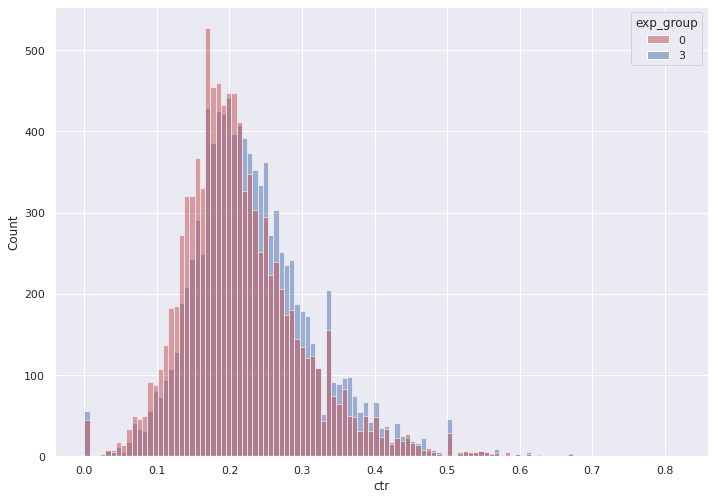

In [108]:
control_group = 0
test_group = 3

linearized_likes_runnig(control_group, test_group)

тест групп 1 2
t-тест между группами 1 и 2 по ctr 0.7094392041270486 0.4780623130874935
анализ тестa между группами 1 и 2 по метрике линеаризованных лайков 6.122579994775972 9.439432187037712e-10


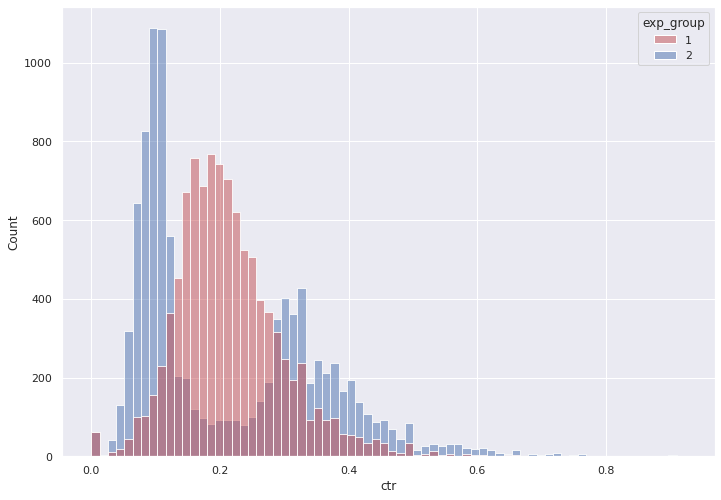

In [109]:
control_group = 1
test_group = 2

linearized_likes_runnig(control_group, test_group)

на глаз две выборки  отличаются на глаз, и теперь с линейным тестом мы получили что они статистически отличаются